In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper
import matplotlib as plt
from sklearn.metrics import accuracy_score
%matplotlib inline

import tensorflow as tf
from keras.layers import Dense, Dropout
from keras.models import Input, Model
from tcn import TCN

Using TensorFlow backend.


In [2]:
df=pd.read_csv("training_table_nonneg.csv")

In [3]:
df=df.groupby(['patientunitstayid']).ffill()
df=df.fillna(df.median())

In [10]:
df.head()

,patientunitstayid,offset,paO2_FiO2,platelets_x_1000,total_bilirubin,urinary_creatinine,creatinine,HCO3,pH,paCO2,direct_bilirubin,excess,ast,bun,calcium,GCS_Score,label
0,141168,516,NaN,209.0,2.6,NaN,1.95,NaN,NaN,NaN,NaN,NaN,59.0,26.0,8.8,NaN,0.0
1,141168,1133,NaN,213.0,4.1,NaN,2.30,NaN,NaN,NaN,NaN,NaN,878.0,27.0,9.2,NaN,0.0
2,141168,1701,NaN,213.0,4.1,173.12,2.30,NaN,NaN,NaN,NaN,NaN,878.0,27.0,9.2,NaN,0.0
3,141168,1805,82.0,213.0,4.1,173.12,2.30,15.0,7.14,46.0,NaN,NaN,878.0,27.0,9.2,NaN,0.0
4,141168,2010,84.0,213.0,4.1,173.12,2.30,14.0,7.14,44.0,NaN,NaN,878.0,27.0,9.2,NaN,0.0


In [4]:
df_train=df.drop(columns=['patientunitstayid','offset'])

In [12]:
X=df_train.iloc[:,:-1]
y=df_train.iloc[:,-1]
scaled_features = StandardScaler().fit_transform(X.values)
scaled_features

array([[        nan, -0.02850532,  0.34217724, ..., -0.08387333,
         0.52806906,         nan],
       [        nan,  0.00517346,  0.78904136, ..., -0.0463176 ,
         0.83407736,         nan],
       [        nan,  0.00517346,  0.78904136, ..., -0.0463176 ,
         0.83407736,         nan],
       ...,
       [        nan, -0.27267646,         nan, ...,         nan,
                nan,  0.71084665],
       [        nan,  0.28302339,         nan, ...,         nan,
                nan,  0.71084665],
       [        nan,  0.28302339,         nan, ...,         nan,
                nan,  0.71084665]])

In [48]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

In [49]:
params = {'eta': 0.1, 'max_depth': 6, 'scale_pos_weight': 1, 'objective': 'reg:linear','subsample':0.25,'verbose': False}

model1=xgb.XGBClassifier(max_depth=6, learning_rate=0.1, n_estimators=100, verbosity=1, silent=None, objective='binary:logistic', booster='gbtree', n_jobs=6)
model1.fit(X_train,y_train)
y_predict=model1.predict(X_test)


In [50]:
print(classification_report(y_test, y_predict))
print('F1 score:', f1_score(y_test, y_predict))
print('Accuracy Score: ',accuracy_score(y_test,y_predict))

              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98    854648
         1.0       1.00      0.01      0.03     36421

    accuracy                           0.96    891069
   macro avg       0.98      0.51      0.50    891069
weighted avg       0.96      0.96      0.94    891069

F1 score: 0.02847244776442568
Accuracy Score:  0.9597158020310436


In [51]:
#We need to undersample the data

# Class count
count_class_0, count_class_1 = df_train.label.value_counts()

# Divide by class
df_class_0 = df_train[df_train['label'] == 0]
df_class_1 = df_train[df_train['label'] == 1]

In [52]:
print(count_class_0, count_class_1)

4274149 181192


Random under-sampling:
1.0    181192
0.0    181192
Name: label, dtype: int64


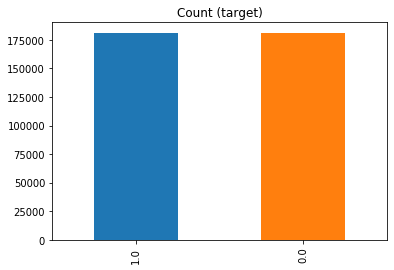

In [53]:
df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_test_under.label.value_counts())

df_test_under.label.value_counts().plot(kind='bar', title='Count (target)')

In [54]:
df_test_under.head()

,paO2_FiO2,platelets_x_1000,total_bilirubin,urinary_creatinine,creatinine,HCO3,pH,paCO2,direct_bilirubin,excess,ast,bun,calcium,GCS_Score,label
3807014,NaN,271.0,1.0,NaN,0.84,29.0,7.470,40.0,0.5,5.0,65.0,40.0,9.1,14.0,0.0
1184657,NaN,233.0,0.5,NaN,0.40,41.4,7.310,83.1,0.0,15.0,71.0,9.0,8.8,12.0,0.0
64418,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0,0.0
3054472,1037.1428,215.0,1.7,NaN,1.15,13.6,7.332,26.9,NaN,6.5,126.0,20.0,7.4,6.0,0.0
162681,126.0000,105.0,NaN,NaN,1.66,24.0,7.510,30.0,NaN,2.0,NaN,32.0,8.8,15.0,0.0


In [55]:
X=df_test_under.iloc[:,:-1]
y=df_test_under.iloc[:,-1]
scaled_features = StandardScaler().fit_transform(X.values)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.1)

model2=xgb.XGBClassifier(max_depth=6, learning_rate=0.01, n_estimators=100, verbosity=1, silent=None, objective='binary:logistic', booster='dart', n_jobs=6)
model2.fit(X_train,y_train)


XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=6,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [56]:
y_predict=model2.predict(X_test)

In [57]:
print(classification_report(y_test, y_predict))
print('F1 score:', f1_score(y_test, y_predict))
print('Accuracy Score: ',accuracy_score(y_test,y_predict))

              precision    recall  f1-score   support

         0.0       0.68      0.53      0.60     18258
         1.0       0.61      0.75      0.67     17981

    accuracy                           0.64     36239
   macro avg       0.65      0.64      0.64     36239
weighted avg       0.65      0.64      0.63     36239

F1 score: 0.6734255606053039
Accuracy Score:  0.639118077209636


In [3]:
x=[0,0,1,1,1,0,1,1]
np.cumsum(x)

array([0, 0, 1, 2, 3, 3, 4, 5], dtype=int32)

In [28]:
cols=list(df.columns)
del cols[-1]


In [29]:
time_priors = [2, 4, 6, 8]
time_duration = 36
time_sep = 24
noDataPoints = 20
def gety_fun(pos, time_prior, data_frame):        
    data_frame = data_frame.iloc[:-pos-1][cols]
    
    return data_frame.iloc[len(data_frame)-noDataPoints:-1].values, time_prior

IndexError: single positional indexer is out-of-bounds